In [20]:
%pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [54]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data_utils
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import sklearn.metrics

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


In [22]:
od.download(
    "https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud"
)

Skipping, found downloaded files in "./creditcardfraud" (use force=True to force download)


In [23]:
df = pd.read_csv("./creditcardfraud/creditcard.csv")

In [24]:
df.shape

(284807, 31)

In [25]:
df.head().T

,0,1,2,3,4
Time,0.000000,0.000000,1.000000,1.000000,2.000000
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737
V3,2.536347,0.166480,1.773209,1.792993,1.548718
V4,1.378155,0.448154,0.379780,-0.863291,0.403034
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193
V6,0.462388,-0.082361,1.800499,1.247203,0.095921
V7,0.239599,-0.078803,0.791461,0.237609,0.592941
V8,0.098698,0.085102,0.247676,0.377436,-0.270533
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739


In [26]:
round(df.groupby("Class")["Class"].count()/df.shape[0],4)

Class
0    0.9983
1    0.0017
Name: Class, dtype: float64

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


<AxesSubplot: >

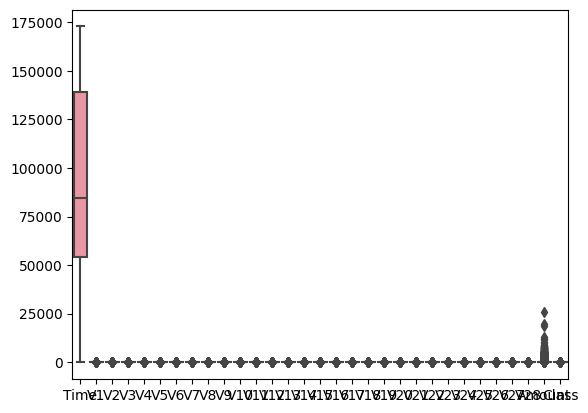

In [28]:
sns.boxplot(data=df)

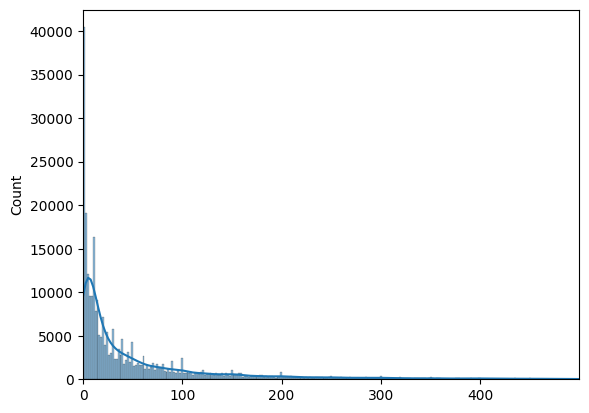

In [29]:
amount = np.array(df['Amount'])
amount = amount[amount < 500]

ax = sns.histplot(amount, kde=True)
ax.set_xlim([min(amount), max(amount)])
plt.show()

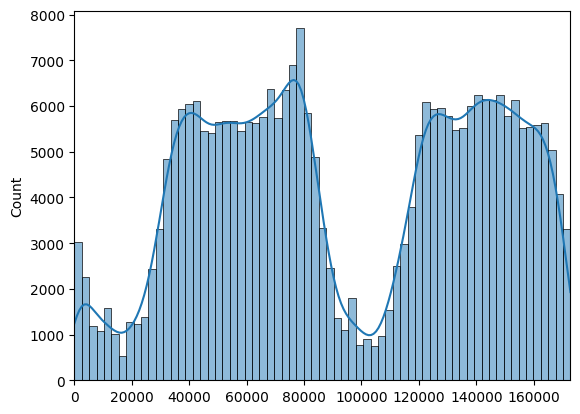

In [30]:
time = np.array(df['Time'])

ax = sns.histplot(time, kde=True)
ax.set_xlim([min(time), max(time)])
plt.show()

In [31]:
df["Timestamp"] = df["Time"] % (60 * 60 * 24)

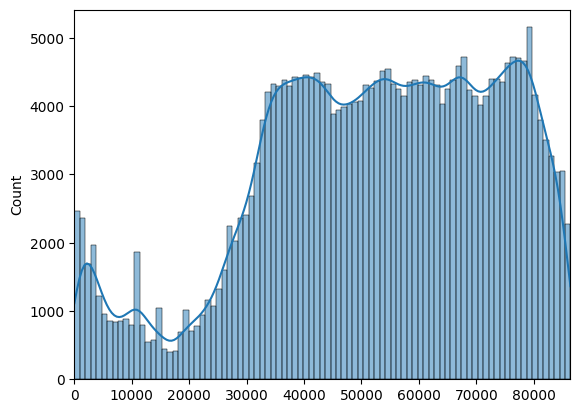

In [32]:
timestamp = np.array(df['Timestamp'])

ax = sns.histplot(timestamp, kde=True)
ax.set_xlim([min(timestamp), max(timestamp)])
plt.show()

In [33]:
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df[['Amount']])
df['scaled_time'] = rob_scaler.fit_transform(df[['Time']])
df['scaled_timestamp'] = rob_scaler.fit_transform(df[['Timestamp']])

df.drop(['Time','Amount', 'Timestamp'], axis=1, inplace=True)

<AxesSubplot: >

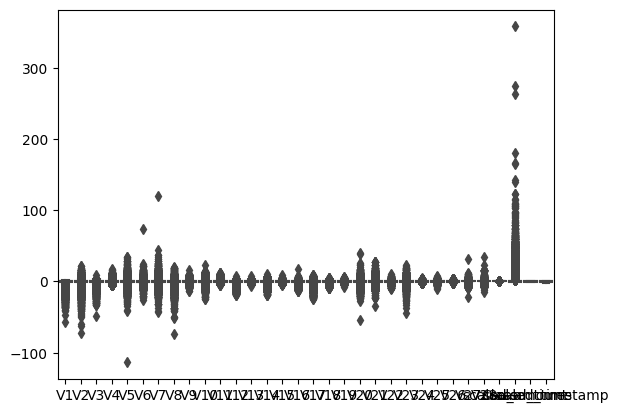

In [34]:
sns.boxplot(data=df)

In [35]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time,scaled_timestamp
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983,-1.719153
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983,-1.719153
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972,-1.719121
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972,-1.719121
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960,-1.719090


In [36]:
df_cp = df.copy()
df_cp = df_cp.sample(frac=1, random_state=0) #Shuffling

fraud_df = df[df["Class"] == 1]
legit_df = df[df["Class"] == 0][:len(fraud_df)]

even_df = pd.concat([fraud_df, legit_df])
even_df = even_df.sample(frac=1, random_state=0)

In [37]:
round(even_df.groupby("Class")["Class"].count()/even_df.shape[0],4)

Class
0    0.5
1    0.5
Name: Class, dtype: float64

In [38]:
even_df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'scaled_amount', 'scaled_time', 'scaled_timestamp'],
      dtype='object')

In [43]:
X = even_df.drop(['Class'], axis=1)
y = even_df['Class']

print(X.shape)
print(y.shape)

(984, 31)
(984,)


In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = torch.from_numpy(np.array(X_train)).float()
Y_train = torch.from_numpy(np.array(Y_train)).float()
X_test = torch.from_numpy(np.array(X_test)).float()
Y_test = torch.from_numpy(np.array(Y_test)).float()

In [62]:
FEATURE_NUM = 31
CLASSES = 2

In [63]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(FEATURE_NUM, 16)
        self.fc2 = nn.Linear(16, 18)
        self.fc3 = nn.Linear(18, 20)
        self.fc4 = nn.Linear(20, 24)
        self.fc5 = nn.Linear(24, 1)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.25)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model(
  (fc1): Linear(in_features=31, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=24, bias=True)
  (fc5): Linear(in_features=24, out_features=1, bias=True)
)

In [64]:
if use_gpu:
    y_pred = model(Variable(X_train[0:3].cuda()))
else:
    y_pred = model(Variable(X_train[0:3]))
print(y_pred)
print(F.softmax(y_pred, dim=1))

tensor([[0.5141],
        [0.5018],
        [0.5082]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)


/home/studio-lab-user/.conda/envs/cesarprojectnn/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
